In [255]:
import numpy as np
import pylab as plt
from glob import glob
import os
from fnmatch import filter
from scipy.stats import zscore, percentileofscore, ttest_ind
import pymc3 as pm
from theano import tensor as tt
from sklearn.impute import SimpleImputer
from tqdm import tqdm

In [2]:
data_dir = '/media/fastdata/brad_changepoint/raw_data/'

In [3]:
file_list = glob(os.path.join(data_dir,"*.npy"))
lfp_files = [x for x in file_list if 'rear' not in x]
rear_files = [x for x in file_list if 'rear' in x]

In [4]:
load_groups = [['cons1','cons2'],['exps1','expl1']]
lfp_groups = [[[x for x in lfp_files if name in x] for name in group] for group in load_groups]
rear_groups = [[[x for x in rear_files if name in x] for name in group] for group in load_groups]
lfp_groups = np.squeeze(np.array(lfp_groups))
rear_groups = np.squeeze(np.array(rear_groups))

In [5]:
lfp_groups

array([['/media/fastdata/brad_changepoint/raw_data/cons1.npy',
        '/media/fastdata/brad_changepoint/raw_data/cons2.npy'],
       ['/media/fastdata/brad_changepoint/raw_data/exps1.npy',
        '/media/fastdata/brad_changepoint/raw_data/expl1.npy']],
      dtype='<U51')

In [6]:
rear_groups

array([['/media/fastdata/brad_changepoint/raw_data/rear_cons1.npy',
        '/media/fastdata/brad_changepoint/raw_data/rear_cons2.npy'],
       ['/media/fastdata/brad_changepoint/raw_data/rear_exps1.npy',
        '/media/fastdata/brad_changepoint/raw_data/rear_expl1.npy']],
      dtype='<U56')

# ==== LFP ====

In [7]:
lfp_dat = np.array([[np.load(x,'r')[:] for x in group] for group in lfp_groups])
zscore_lfp_dat = np.array([[zscore(np.load(x,'r')[:],axis=-1) for x in group] for group in lfp_groups])

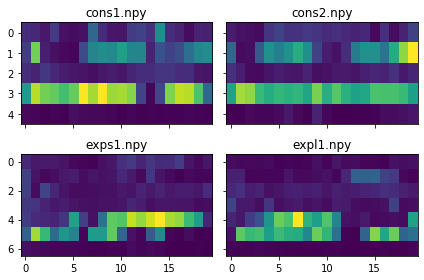

In [8]:
inds = list(np.ndindex(lfp_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(lfp_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(lfp_groups[this_ind]))
plt.tight_layout()

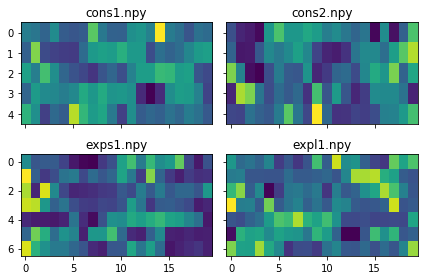

In [9]:
inds = list(np.ndindex(lfp_dat.shape))
fig,ax = plt.subplots(2,2,sharex=True, sharey = 'row')
for this_ind in inds:
    ax[this_ind].imshow(zscore_lfp_dat[this_ind],aspect='auto')
    ax[this_ind].set_title(os.path.basename(lfp_groups[this_ind]))
plt.tight_layout()

In [11]:
lfp_groups.flatten()

array(['/media/fastdata/brad_changepoint/raw_data/cons1.npy',
       '/media/fastdata/brad_changepoint/raw_data/cons2.npy',
       '/media/fastdata/brad_changepoint/raw_data/exps1.npy',
       '/media/fastdata/brad_changepoint/raw_data/expl1.npy'],
      dtype='<U51')

### Single Changepoint on Means

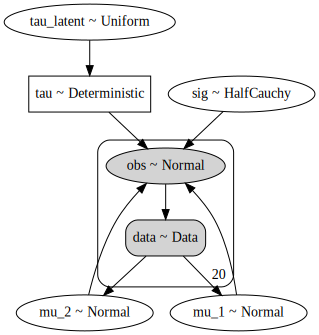

In [15]:
with pm.Model() as mean_model:
    
    # Define shared "Data" holder to fit same model to different datasets 
    data = pm.Data("data", zscore_lfp_dat[0,0][0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma = pm.HalfCauchy('sig', 1)

    idx = np.arange(np.array(mean_model["data"].get_value()).shape[-1])
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2

    observation = pm.Normal("obs", mu=mu_, sigma = sigma, observed=data)

pm.model_to_graphviz(mean_model)

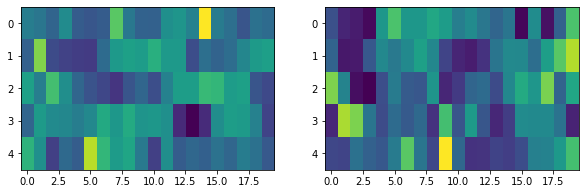

In [13]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
for this_ax,dat in zip(ax,zscore_lfp_dat[0]):
    this_ax.imshow(dat,aspect='auto')

### ==== Diff Changes ====

In [12]:
exp_diff_lfp = np.diff(zscore_lfp_dat[1], axis=0)[0]
con_diff_lfp = np.diff(zscore_lfp_dat[0], axis=0)[0]

In [357]:
# Generate one trace for each dataset
exp_diff_traces = []
for data_vals in exp_diff_lfp:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        exp_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
# Generate one trace for each dataset
con_diff_traces = []
for data_vals in con_diff_lfp:
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        con_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1946.74draws/s]
The acceptance probability does not match the target. It is 0.686238071019429, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7206720900025484, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1958.51draws/s]
The acceptance probability does not match the target. It is 0.8922050945720862, but should be close to 0.8. Try to increase the nu

The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3019.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1599.74draws/s]
The acceptance probability does not match the target. It is 0.5343179757734284, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]

Sampling 4 chains, 0 divergences: 100%|██████████| 4

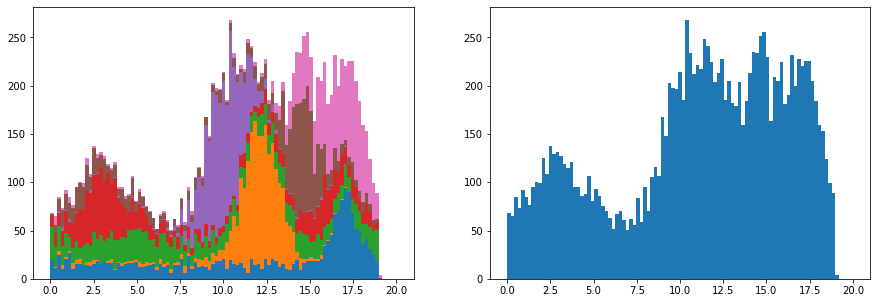

In [358]:
exp_diff_tau_array = np.array([this_trace["tau"] for this_trace in exp_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(exp_diff_tau_array.T, bins, stacked = 'true');
ax[1].hist(exp_diff_tau_array.flatten(), bins, stacked = 'true');

#ax[0,0].set_ylabel('Con');
#ax[1,0].set_ylabel('Exp');

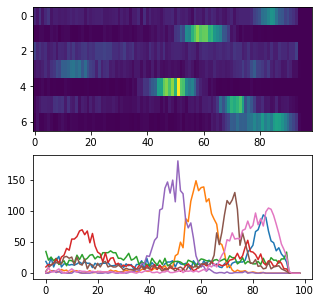

In [359]:
exp_diff_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp_diff_tau_array])
fig,ax = plt.subplots(2,1, figsize = (5,5))
ax[0].imshow(exp_diff_tau_hists,aspect='auto');
ax[1].plot(exp_diff_tau_hists.T);

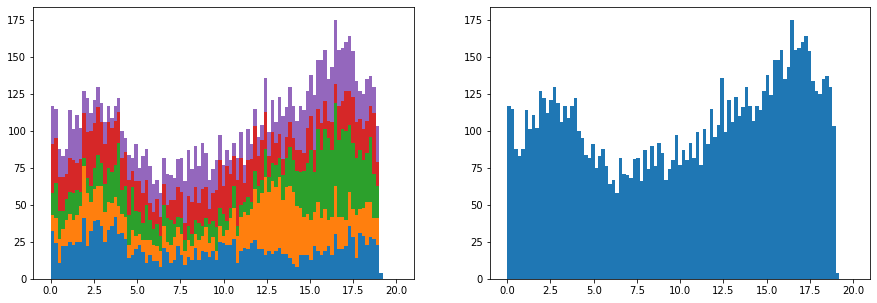

In [360]:
con_diff_tau_array = np.array([this_trace["tau"] for this_trace in con_diff_traces])

bins = np.linspace(0,20,100)
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].hist(con_diff_tau_array.T, bins, stacked = 'true');
ax[1].hist(con_diff_tau_array.flatten(), bins, stacked = 'true');

#ax[0,0].set_ylabel('Con');
#ax[1,0].set_ylabel('Exp');

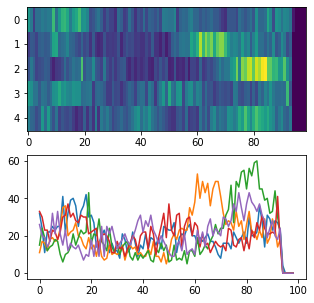

In [361]:
con_diff_tau_hists = np.array([np.histogram(x, bins)[0] for x in con_diff_tau_array])
fig,ax = plt.subplots(2,1, figsize = (5,5))
ax[0].imshow(con_diff_tau_hists,aspect='auto');
ax[1].plot(con_diff_tau_hists.T);

### ===== Comparison ===== 

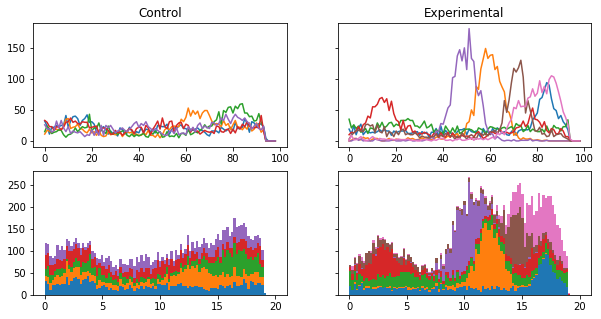

In [362]:
fig,ax = plt.subplots(2,2, figsize = (10,5), sharey = 'row')
ax[0,0].plot(con_diff_tau_hists.T);
ax[0,1].plot(exp_diff_tau_hists.T);
ax[1,0].hist(con_diff_tau_array.T, bins, stacked = 'true');
ax[1,1].hist(exp_diff_tau_array.T, bins, stacked = 'true');
ax[0,0].set_title('Control');
ax[0,1].set_title('Experimental');

# Repeat above with shuffled data

In [363]:
shuffle_num = 50
con_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in con_diff_lfp] for i in range(shuffle_num)])
exp_shuffle_dat = np.array(\
                           [[np.random.permutation(data_vals) \
                             for data_vals in exp_diff_lfp] for i in range(shuffle_num)])

In [364]:
con_inds = np.array(list(np.ndindex(con_shuffle_dat.shape[:-1])))
exp_inds = np.array(list(np.ndindex(exp_shuffle_dat.shape[:-1])))

In [365]:
# Generate one trace for each dataset
exp_shuffle_diff_traces = []
for this_ind in tqdm(exp_inds):
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": exp_shuffle_dat[tuple(this_ind)]})
        exp_shuffle_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))
        
# Generate one trace for each dataset
con_shuffle_diff_traces = []
for this_ind in tqdm(con_inds):
    with mean_model:
        # Switch out the observed dataset
        pm.set_data({"data": con_shuffle_dat[tuple(this_ind)]})
        con_shuffle_diff_traces.append(pm.sample())#pm.sample(step = pm.Metropolis()))


  0%|          | 0/350 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 57/4000 [00:00<00:06, 569.41draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 210/4000 [00:00<00:05, 701.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 426/4000 [00:00<00:04, 879.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 636/4000 [00:00<00:03, 1064.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 901/4000 [00:00<00:02, 1296.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 1143/4000 [00:00<00:01, 1505.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 1411/4000 [00:00<00:01, 1733.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1689/4000 [00:00<00:01, 1951.01draws/s

Sampling 4 chains, 0 divergences:  82%|████████▏ | 3292/4000 [00:01<00:00, 2499.77draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 3545/4000 [00:01<00:00, 2502.16draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1947.83draws/s]
The number of effective samples is smaller than 25% for some parameters.

  2%|▏         | 8/350 [00:34<23:22,  4.10s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 31/4000 [00:00<00:12, 309.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 254/4000 [00:00<00:08, 417.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 494/4000 [00:00<00:06, 554.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 731/4000 [00:00<00:04, 719.93draws/s]

Sampling 

Sampling 4 chains, 0 divergences:  50%|████▉     | 1983/4000 [00:01<00:01, 1985.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 2213/4000 [00:01<00:00, 2068.70draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 2437/4000 [00:01<00:00, 2116.96draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2673/4000 [00:01<00:00, 2184.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2907/4000 [00:01<00:00, 2226.60draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 3142/4000 [00:01<00:00, 2260.91draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 3380/4000 [00:01<00:00, 2295.20draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 3629/4000 [00:01<00:00, 2350.30draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2007.81draws/s]
The number of effective samples is smaller than 25% for some parameters.

  5%|▍         | 16/350 [01:07<22:17,  4.00s/it]Auto-assigning NUTS sampler...
Initializing NUTS us

Sampling 4 chains, 0 divergences:   1%|          | 48/4000 [00:00<00:08, 469.63draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 211/4000 [00:00<00:06, 597.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 432/4000 [00:00<00:04, 764.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 648/4000 [00:00<00:03, 947.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 869/4000 [00:00<00:02, 1143.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 1120/4000 [00:00<00:02, 1365.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 1377/4000 [00:00<00:01, 1588.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 1605/4000 [00:00<00:01, 1746.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1848/4000 [00:00<00:01, 1906.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 2084/4000 [00:01<00:00, 2022.02draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 2348/4000 [00:01<00:00, 2174.33draws/s]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 110/4000 [00:00<00:03, 1098.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 298/4000 [00:00<00:02, 1253.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 537/4000 [00:00<00:02, 1461.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 732/4000 [00:00<00:02, 1579.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 935/4000 [00:00<00:01, 1691.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 1156/4000 [00:00<00:01, 1818.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 1381/4000 [00:00<00:01, 1929.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1622/4000 [00:00<00:01, 2050.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1833/4000 [00

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 93/4000 [00:00<00:04, 924.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 312/4000 [00:00<00:03, 1117.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 533/4000 [00:00<00:02, 1312.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 761/4000 [00:00<00:02, 1503.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 999/4000 [00:00<00:01, 1687.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1239/4000 [00:00<00:01, 1851.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1438/4000 [00:00<00:01, 1874.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 1659/4000 [00:00<00:01, 1963.20draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1873/4000 [00:00<00:01, 2012.00draws/s]

Sampling 4 chains, 

Sampling 4 chains, 0 divergences:  79%|███████▉  | 3177/4000 [00:01<00:00, 2267.38draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 3408/4000 [00:01<00:00, 2279.70draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 3637/4000 [00:01<00:00, 1811.30draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1772.58draws/s]
The acceptance probability does not match the target. It is 0.7207806684706796, but should be close to 0.8. Try to increase the number of tuning steps.

 12%|█▏        | 43/350 [02:56<22:51,  4.47s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 63/4000 [00:00<00:06, 626.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 257/4000 [00:00<00:04, 786.03draws/s]

Sampling 4 chains

Sampling 4 chains, 0 divergences:  16%|█▌        | 632/4000 [00:00<00:03, 994.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 833/4000 [00:00<00:02, 1171.86draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1035/4000 [00:00<00:02, 1339.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1245/4000 [00:00<00:01, 1502.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 1457/4000 [00:00<00:01, 1644.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1647/4000 [00:00<00:01, 1707.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1836/4000 [00:01<00:01, 1724.43draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2045/4000 [00:01<00:01, 1819.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 2253/4000 [00:01<00:00, 1890.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 2450/4000 [00:01<00:00, 1911.84draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2666/4000 [00:01<00:00, 1978.44d

Sampling 4 chains, 0 divergences:  76%|███████▌  | 3023/4000 [00:01<00:00, 1898.83draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 3216/4000 [00:01<00:00, 1907.49draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 3408/4000 [00:01<00:00, 1910.19draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 3601/4000 [00:02<00:00, 1915.37draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 3796/4000 [00:02<00:00, 1921.70draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1658.63draws/s]
The acceptance probability does not match the target. It is 0.6585083925688142, but should be close to 0.8. Try to increase the number of tuning steps.

 17%|█▋        | 58/350 [03:57<19:54,  4.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 c

Sampling 4 chains, 0 divergences:  18%|█▊        | 703/4000 [00:00<00:03, 1057.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 907/4000 [00:00<00:02, 1235.63draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 1120/4000 [00:00<00:02, 1410.69draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 1372/4000 [00:00<00:01, 1623.30draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 1588/4000 [00:00<00:01, 1753.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 1794/4000 [00:00<00:01, 1816.11draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 2019/4000 [00:01<00:01, 1925.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2249/4000 [00:01<00:00, 2022.45draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2486/4000 [00:01<00:00, 2114.63draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 2716/4000 [00:01<00:00, 2165.49draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 2968/4000 [00:01<00:00, 2259.44

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1867.23draws/s]
The acceptance probability does not match the target. It is 0.7019862529783606, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6602866866369865, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

 21%|██        | 73/350 [04:58<20:36,  4.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 160/4000 [00:00<00:02, 1591.73draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 401/4000 [00:00<00:02, 1772.19draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 672/4000 [00:0

Sampling 4 chains, 0 divergences:  31%|███       | 1227/4000 [00:00<00:02, 1124.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 1468/4000 [00:00<00:01, 1338.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1671/4000 [00:00<00:01, 1491.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1892/4000 [00:01<00:01, 1652.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2107/4000 [00:01<00:01, 1774.87draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 2338/4000 [00:01<00:00, 1907.30draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 2555/4000 [00:01<00:00, 1978.18draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 2782/4000 [00:01<00:00, 2056.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 3012/4000 [00:01<00:00, 2123.40draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 3259/4000 [00:01<00:00, 2213.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 3489/4000 [00:01<00:00, 2220.

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 102/4000 [00:00<00:03, 1018.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 322/4000 [00:00<00:03, 1213.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 567/4000 [00:00<00:02, 1428.57draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 812/4000 [00:00<00:01, 1631.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1026/4000 [00:00<00:01, 1756.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1260/4000 [00:00<00:01, 1897.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 1457/4000 [00:00<00:01, 1896.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 1725/4000 [00:00<00:01, 2077.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 1958/4000 [00:00<00:00, 2141.73draws/s]

Sampling 4 chain

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 77/4000 [00:00<00:05, 764.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 317/4000 [00:00<00:03, 960.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 568/4000 [00:00<00:02, 1178.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 802/4000 [00:00<00:02, 1383.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1029/4000 [00:00<00:01, 1564.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1291/4000 [00:00<00:01, 1778.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 1590/4000 [00:00<00:01, 2023.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1886/4000 [00:00<00:00, 2235.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 2146/4000 [00:00<00:00, 2333.53draws/s]

Sampling 4 chains, 

Sampling 4 chains, 0 divergences:  46%|████▌     | 1844/4000 [00:00<00:01, 1939.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 2082/4000 [00:01<00:00, 2052.36draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 2326/4000 [00:01<00:00, 2150.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 2571/4000 [00:01<00:00, 2231.79draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 2806/4000 [00:01<00:00, 2263.30draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3064/4000 [00:01<00:00, 2346.40draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3305/4000 [00:01<00:00, 2352.05draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 3545/4000 [00:01<00:00, 2329.67draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 3782/4000 [00:01<00:00, 1905.13draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1930.80draws/s]
The number of effective samples is smaller than 25% for some parameters.

 27%|██

Sampling 4 chains, 0 divergences:   7%|▋         | 282/4000 [00:00<00:04, 815.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 518/4000 [00:00<00:03, 1015.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 744/4000 [00:00<00:02, 1215.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 988/4000 [00:00<00:02, 1431.31draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 1200/4000 [00:00<00:01, 1585.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 1405/4000 [00:00<00:01, 1699.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1645/4000 [00:00<00:01, 1862.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 1858/4000 [00:00<00:01, 1933.29draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 2068/4000 [00:01<00:00, 1975.70draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2290/4000 [00:01<00:00, 2041.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2527/4000 [00:01<00:00, 2129.38dra

Sampling 4 chains, 0 divergences:   6%|▋         | 254/4000 [00:00<00:07, 510.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 473/4000 [00:00<00:05, 663.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 660/4000 [00:00<00:04, 822.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 841/4000 [00:00<00:03, 982.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1022/4000 [00:00<00:02, 1137.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1224/4000 [00:00<00:02, 1308.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1421/4000 [00:00<00:01, 1454.77draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 1601/4000 [00:00<00:01, 1525.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 1795/4000 [00:01<00:01, 1628.25draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 1999/4000 [00:01<00:01, 1732.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 2194/4000 [00:01<00:01, 1792.57draws/

Sampling 4 chains, 0 divergences:  89%|████████▉ | 3563/4000 [00:01<00:00, 2602.70draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2092.77draws/s]
The number of effective samples is smaller than 25% for some parameters.

 34%|███▍      | 119/350 [08:03<15:25,  4.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 29/4000 [00:00<00:13, 289.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 201/4000 [00:00<00:09, 385.03draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 417/4000 [00:00<00:07, 510.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 649/4000 [00:00<00:05, 666.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 881/4000 [00:00<00:03, 847.76draws/s]

Sampling 

Sampling 4 chains, 0 divergences:  21%|██▏       | 859/4000 [00:00<00:01, 1953.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 1105/4000 [00:00<00:01, 2079.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 1386/4000 [00:00<00:01, 2255.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1631/4000 [00:00<00:01, 2307.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1882/4000 [00:00<00:00, 2363.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 2166/4000 [00:00<00:00, 2486.07draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 2458/4000 [00:01<00:00, 2597.57draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2754/4000 [00:01<00:00, 2693.44draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 3040/4000 [00:01<00:00, 2735.26draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3322/4000 [00:01<00:00, 2759.85draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 3632/4000 [00:01<00:00, 2853.4

The acceptance probability does not match the target. It is 0.7094351524024598, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6803180378097278, but should be close to 0.8. Try to increase the number of tuning steps.

 38%|███▊      | 134/350 [09:03<14:13,  3.95s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 49/4000 [00:00<00:08, 488.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 215/4000 [00:00<00:06, 619.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 428/4000 [00:00<00:04, 786.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 635/4000 [00:00<00:03, 966.43draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 

Sampling 4 chains, 0 divergences:  72%|███████▏  | 2879/4000 [00:01<00:00, 2677.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 3176/4000 [00:01<00:00, 2757.25draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 3459/4000 [00:01<00:00, 2738.36draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2188.66draws/s]

 41%|████      | 142/350 [09:35<13:38,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 35/4000 [00:00<00:11, 349.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 203/4000 [00:00<00:08, 457.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 421/4000 [00:00<00:05, 599.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 629/4000 [00:00<00:04, 762.

Sampling 4 chains, 0 divergences:  87%|████████▋ | 3478/4000 [00:01<00:00, 2278.14draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 3721/4000 [00:01<00:00, 2321.14draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1899.77draws/s]

 43%|████▎     | 150/350 [10:08<15:22,  4.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 53/4000 [00:00<00:07, 528.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 287/4000 [00:00<00:05, 687.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 505/4000 [00:00<00:04, 865.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 718/4000 [00:00<00:03, 1052.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 941/4000 [00:00<00:02, 1249.

Sampling 4 chains, 0 divergences:  40%|████      | 1607/4000 [00:00<00:01, 1725.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1846/4000 [00:00<00:01, 1880.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2128/4000 [00:01<00:00, 2088.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 2366/4000 [00:01<00:00, 2167.75draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 2624/4000 [00:01<00:00, 2275.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 2880/4000 [00:01<00:00, 2353.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 3137/4000 [00:01<00:00, 2413.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 3405/4000 [00:01<00:00, 2485.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 3661/4000 [00:01<00:00, 2502.72draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1985.78draws/s]
The number of effective samples is smaller than 25% for some parameters.

 45%|██

Sampling 4 chains, 0 divergences:  41%|████      | 1642/4000 [00:00<00:01, 2017.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1880/4000 [00:00<00:01, 2112.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2127/4000 [00:01<00:00, 2207.58draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 2365/4000 [00:01<00:00, 2256.52draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 2594/4000 [00:01<00:00, 2260.66draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 2835/4000 [00:01<00:00, 2299.72draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3085/4000 [00:01<00:00, 2354.18draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3322/4000 [00:01<00:00, 2342.58draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 3558/4000 [00:01<00:00, 2308.94draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1995.09draws/s]

 47%|████▋     | 166/350 [11:11<12:01,  3.92s/it]Auto-assigning NUTS sampler...


Sampling 4 chains, 0 divergences:  40%|███▉      | 1580/4000 [00:00<00:01, 1957.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1771/4000 [00:00<00:01, 1870.82draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 1984/4000 [00:01<00:01, 1938.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 2206/4000 [00:01<00:00, 2011.12draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 2428/4000 [00:01<00:00, 2068.41draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 2636/4000 [00:01<00:00, 2046.68draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 2855/4000 [00:01<00:00, 2086.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3065/4000 [00:01<00:00, 2049.97draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 3285/4000 [00:01<00:00, 2087.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 3500/4000 [00:01<00:00, 2103.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 3711/4000 [00:01<00:00, 1838.

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 60/4000 [00:00<00:06, 595.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 245/4000 [00:00<00:05, 746.39draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 434/4000 [00:00<00:03, 911.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 618/4000 [00:00<00:03, 1073.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 832/4000 [00:00<00:02, 1261.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 1007/4000 [00:00<00:02, 1375.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1226/4000 [00:00<00:01, 1546.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1445/4000 [00:00<00:01, 1693.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 1653/4000 [00:00<00:01, 1792.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1874/4000 [00:01<00:01, 1898.92draws/s]

Sampling 4

Sampling 4 chains, 0 divergences:  70%|██████▉   | 2787/4000 [00:01<00:00, 1906.97draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 2988/4000 [00:01<00:00, 1935.65draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 3183/4000 [00:01<00:00, 1916.00draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 3379/4000 [00:01<00:00, 1928.30draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 3589/4000 [00:01<00:00, 1975.87draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1695.84draws/s]
The acceptance probability does not match the target. It is 0.6957229878817324, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

 54%|█████▍    | 189/350 [12:44<11:06,  4.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains

Sampling 4 chains, 0 divergences:  41%|████      | 1642/4000 [00:00<00:01, 1505.42draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1868/4000 [00:00<00:01, 1670.43draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2127/4000 [00:01<00:01, 1868.31draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 2385/4000 [00:01<00:00, 2032.54draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2671/4000 [00:01<00:00, 2224.85draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2926/4000 [00:01<00:00, 2293.74draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 3202/4000 [00:01<00:00, 2414.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 3462/4000 [00:01<00:00, 2440.37draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 3719/4000 [00:01<00:00, 1902.03draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1956.18draws/s]

 56%|█████▋    | 197/350 [13:14<09:45,  3.82s/it]Auto-assigning NUTS sampler...


Sampling 4 chains, 0 divergences:   8%|▊         | 329/4000 [00:00<00:03, 1124.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 565/4000 [00:00<00:02, 1333.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 775/4000 [00:00<00:02, 1495.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 1010/4000 [00:00<00:01, 1677.94draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 1219/4000 [00:00<00:01, 1781.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 1411/4000 [00:00<00:01, 1819.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1622/4000 [00:00<00:01, 1896.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 1818/4000 [00:00<00:01, 1903.92draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 2013/4000 [00:01<00:01, 1911.45draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2239/4000 [00:01<00:00, 2002.86draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2463/4000 [00:01<00:00, 2066.95d

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 108/4000 [00:00<00:03, 1079.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 339/4000 [00:00<00:02, 1284.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 580/4000 [00:00<00:02, 1493.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 805/4000 [00:00<00:01, 1658.56draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1039/4000 [00:00<00:01, 1815.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1268/4000 [00:00<00:01, 1933.83draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1531/4000 [00:00<00:01, 2098.99draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 1788/4000 [00:00<00:00, 2220.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 2020/4000 [00:00<00:00, 2246.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2296/4000 [00:01<00:00, 2379.33draws/s]

Sampl

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1988.64draws/s]
The number of effective samples is smaller than 25% for some parameters.

 63%|██████▎   | 220/350 [14:48<08:25,  3.89s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 76/4000 [00:00<00:05, 757.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 313/4000 [00:00<00:03, 951.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 517/4000 [00:00<00:03, 1132.26draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 700/4000 [00:00<00:02, 1277.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 921/4000 [00:00<00:02, 1462.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 1126/4000 [00:00<00:01, 1598.72draws/s]

Sampli

Sampling 4 chains, 0 divergences:  65%|██████▌   | 2619/4000 [00:01<00:00, 2012.91draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 2850/4000 [00:01<00:00, 2090.64draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3069/4000 [00:01<00:00, 2060.49draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 3298/4000 [00:01<00:00, 2123.47draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 3516/4000 [00:01<00:00, 1945.25draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 3717/4000 [00:01<00:00, 1831.44draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1797.23draws/s]
The acceptance probability does not match the target. It is 0.715319397603535, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

 65%|██████▌   | 228/350 [15:21<08:12,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multipr

Sampling 4 chains, 0 divergences:  54%|█████▍    | 2167/4000 [00:01<00:00, 2280.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 2449/4000 [00:01<00:00, 2417.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 2719/4000 [00:01<00:00, 2495.69draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 2987/4000 [00:01<00:00, 2546.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 3264/4000 [00:01<00:00, 2609.02draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 3533/4000 [00:01<00:00, 2631.70draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2094.75draws/s]
The number of effective samples is smaller than 25% for some parameters.

 67%|██████▋   | 236/350 [15:53<08:17,  4.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1669/4000 [00:00<00:01, 1504.98draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 1912/4000 [00:00<00:01, 1698.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 2140/4000 [00:01<00:01, 1838.81draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 2390/4000 [00:01<00:00, 1996.44draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 2650/4000 [00:01<00:00, 2145.67draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 2891/4000 [00:01<00:00, 2194.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 3148/4000 [00:01<00:00, 2294.16draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 3392/4000 [00:01<00:00, 2317.98draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 3634/4000 [00:01<00:00, 2048.79draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1993.44draws/s]
The number of effective samples is smaller than 25% for some parameters.

 70%|██

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 20/4000 [00:00<00:19, 199.70draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 241/4000 [00:00<00:13, 274.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 485/4000 [00:00<00:09, 374.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 695/4000 [00:00<00:06, 496.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 864/4000 [00:00<00:04, 629.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1042/4000 [00:00<00:03, 779.84draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 1220/4000 [00:00<00:02, 937.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1427/4000 [00:00<00:02, 1121.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1639/4000 [00:00<00:01, 1305.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1836/4000 [00:01<00:01, 1449.73draws/s]

Sampling 4 cha

Sampling 4 chains, 0 divergences:  61%|██████    | 2435/4000 [00:01<00:00, 2056.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 2647/4000 [00:01<00:00, 2025.49draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 2854/4000 [00:01<00:00, 1991.37draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3090/4000 [00:01<00:00, 2086.66draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3324/4000 [00:01<00:00, 2151.02draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 3545/4000 [00:01<00:00, 2165.06draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1910.08draws/s]
The acceptance probability does not match the target. It is 0.6658412472458343, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

 73%|███████▎  | 255/350 [17:09<06:25,  4.06s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multip

Sampling 4 chains, 0 divergences:  20%|██        | 805/4000 [00:00<00:01, 1776.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1075/4000 [00:00<00:01, 1978.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 1330/4000 [00:00<00:01, 2120.69draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 1595/4000 [00:00<00:01, 2253.49draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1824/4000 [00:00<00:00, 2261.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 2065/4000 [00:00<00:00, 2303.67draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 2351/4000 [00:01<00:00, 2444.63draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 2627/4000 [00:01<00:00, 2529.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2925/4000 [00:01<00:00, 2649.52draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 3207/4000 [00:01<00:00, 2698.29draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 3513/4000 [00:01<00:00, 2793.7

Sampling 4 chains, 0 divergences:   1%|          | 29/4000 [00:00<00:13, 289.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 156/4000 [00:00<00:10, 376.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 335/4000 [00:00<00:07, 493.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 543/4000 [00:00<00:05, 640.03draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 774/4000 [00:00<00:03, 817.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 1011/4000 [00:00<00:02, 1017.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1226/4000 [00:00<00:02, 1207.54draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 1453/4000 [00:00<00:01, 1404.33draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1673/4000 [00:00<00:01, 1574.67draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 1900/4000 [00:01<00:01, 1733.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2137/4000 [00:01<00:00, 1885.17draws/s]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 27/4000 [00:00<00:14, 269.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 166/4000 [00:00<00:10, 356.01draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 388/4000 [00:00<00:07, 475.87draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 630/4000 [00:00<00:05, 626.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 856/4000 [00:00<00:03, 800.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1068/4000 [00:00<00:02, 983.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 1256/4000 [00:00<00:02, 1146.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 1468/4000 [00:00<00:01, 1328.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1696/4000 [00:00<00:

Sampling 4 chains, 0 divergences:  43%|████▎     | 1724/4000 [00:00<00:01, 2109.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 1943/4000 [00:00<00:00, 2132.58draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 2192/4000 [00:01<00:00, 2225.85draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 2443/4000 [00:01<00:00, 2302.90draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2678/4000 [00:01<00:00, 2315.59draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2935/4000 [00:01<00:00, 2383.15draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 3177/4000 [00:01<00:00, 2391.57draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 3420/4000 [00:01<00:00, 2397.63draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 3682/4000 [00:01<00:00, 2459.83draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2018.82draws/s]

 81%|████████  | 282/350 [18:57<04:30,  3.97s/it]Auto-assigning NUTS sampler...


Sampling 4 chains, 0 divergences:  55%|█████▌    | 2214/4000 [00:01<00:00, 2165.15draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 2440/4000 [00:01<00:00, 2191.76draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2693/4000 [00:01<00:00, 2282.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2934/4000 [00:01<00:00, 2318.53draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 3170/4000 [00:01<00:00, 2329.63draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 3405/4000 [00:01<00:00, 2334.31draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 3640/4000 [00:01<00:00, 2336.33draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2037.91draws/s]

 83%|████████▎ | 290/350 [19:28<03:44,  3.75s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 

Sampling 4 chains, 0 divergences:  47%|████▋     | 1862/4000 [00:00<00:01, 2069.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 2096/4000 [00:01<00:00, 2141.96draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 2354/4000 [00:01<00:00, 2256.63draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 2591/4000 [00:01<00:00, 2287.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 2848/4000 [00:01<00:00, 2363.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3087/4000 [00:01<00:00, 2342.71draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3323/4000 [00:01<00:00, 2312.62draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 3575/4000 [00:01<00:00, 2368.83draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2017.12draws/s]

 85%|████████▌ | 298/350 [20:00<03:17,  3.79s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS

Sampling 4 chains, 0 divergences:   4%|▍         | 163/4000 [00:00<00:07, 488.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 354/4000 [00:00<00:05, 628.92draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 593/4000 [00:00<00:04, 807.28draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 848/4000 [00:00<00:03, 1014.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1082/4000 [00:00<00:02, 1221.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 1336/4000 [00:00<00:01, 1446.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 1550/4000 [00:00<00:01, 1601.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1760/4000 [00:00<00:01, 1719.97draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 1975/4000 [00:01<00:01, 1828.35draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2231/4000 [00:01<00:00, 1998.28draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2488/4000 [00:01<00:00, 2139.00draws

NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 62/4000 [00:00<00:06, 619.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 245/4000 [00:00<00:04, 772.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 454/4000 [00:00<00:03, 952.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 647/4000 [00:00<00:02, 1122.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 851/4000 [00:00<00:02, 1297.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1048/4000 [00:00<00:02, 1445.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 1216/4000 [00:00<00:01, 1499.65draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1440/4000 [00:00<00:01, 1662.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1661/4000 [00:00<00:01, 1795.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1880/4000 [00


 91%|█████████ | 317/350 [21:15<02:05,  3.80s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 145/4000 [00:00<00:02, 1447.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 389/4000 [00:00<00:02, 1648.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 641/4000 [00:00<00:01, 1838.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 903/4000 [00:00<00:01, 2017.07draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 1196/4000 [00:00<00:01, 2225.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 1494/4000 [00:00<00:01, 2407.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1758/4000 [00:00<00:00, 2471.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2048/4000 [00:00<00:00,


 93%|█████████▎| 325/350 [21:48<01:38,  3.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 54/4000 [00:00<00:07, 539.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 239/4000 [00:00<00:05, 684.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 465/4000 [00:00<00:04, 864.93draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 669/4000 [00:00<00:03, 1045.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 910/4000 [00:00<00:02, 1257.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 1164/4000 [00:00<00:01, 1481.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 1385/4000 [00:00<00:01, 1643.54draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 1609/4000 [00:00<00:01, 1786


 95%|█████████▌| 333/350 [22:19<01:05,  3.83s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 152/4000 [00:00<00:02, 1511.85draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 361/4000 [00:00<00:02, 1647.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 627/4000 [00:00<00:01, 1859.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 826/4000 [00:00<00:01, 1895.33draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 1052/4000 [00:00<00:01, 1990.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 1310/4000 [00:00<00:01, 2136.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1538/4000 [00:00<00:01, 2174.96draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1771/4000 [00:00<00:01,

Sampling 4 chains, 0 divergences:  85%|████████▍ | 3386/4000 [00:01<00:00, 2359.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 3626/4000 [00:01<00:00, 2370.47draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1974.69draws/s]
The number of effective samples is smaller than 25% for some parameters.

 97%|█████████▋| 341/350 [22:52<00:35,  3.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 61/4000 [00:00<00:06, 608.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 251/4000 [00:00<00:04, 764.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 475/4000 [00:00<00:03, 952.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 685/4000 [00:00<00:02, 1139.27draws/s]

Sampli

Sampling 4 chains, 0 divergences:  40%|███▉      | 1590/4000 [00:00<00:01, 1990.15draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 1805/4000 [00:00<00:01, 2033.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2026/4000 [00:01<00:00, 2082.65draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2264/4000 [00:01<00:00, 2159.89draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2480/4000 [00:01<00:00, 2046.02draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 2712/4000 [00:01<00:00, 2120.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2926/4000 [00:01<00:00, 2052.50draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 3133/4000 [00:01<00:00, 2025.32draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 3359/4000 [00:01<00:00, 2089.90draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 3570/4000 [00:01<00:00, 2038.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 3776/4000 [00:01<00:00, 1830.

Sampling 4 chains, 0 divergences:  78%|███████▊  | 3136/4000 [00:01<00:00, 2248.21draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 3370/4000 [00:01<00:00, 2243.53draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 3603/4000 [00:01<00:00, 2266.56draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1900.34draws/s]
The number of effective samples is smaller than 25% for some parameters.

  2%|▏         | 6/250 [00:24<16:19,  4.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 51/4000 [00:00<00:07, 505.85draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 226/4000 [00:00<00:05, 642.98draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 470/4000 [00:00<00:04, 825.10draws/s]

Samplin

Sampling 4 chains, 0 divergences:  15%|█▌        | 607/4000 [00:00<02:01, 27.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 842/4000 [00:00<01:19, 39.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1036/4000 [00:00<00:52, 56.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1264/4000 [00:00<00:34, 79.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1514/4000 [00:00<00:22, 112.09draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1751/4000 [00:00<00:14, 156.93draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 1995/4000 [00:01<00:09, 218.16draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2247/4000 [00:01<00:05, 300.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2508/4000 [00:01<00:03, 409.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2754/4000 [00:01<00:02, 545.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 3011/4000 [00:01<00:01, 714.06draws/s]

Sampl

Sampling 4 chains, 0 divergences:  22%|██▏       | 874/4000 [00:00<00:02, 1445.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1063/4000 [00:00<00:01, 1554.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1279/4000 [00:00<00:01, 1694.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1526/4000 [00:00<00:01, 1869.45draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1758/4000 [00:00<00:01, 1983.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 1992/4000 [00:01<00:00, 2077.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2241/4000 [00:01<00:00, 2186.36draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2513/4000 [00:01<00:00, 2318.98draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2769/4000 [00:01<00:00, 2385.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 3014/4000 [00:01<00:00, 2336.73draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 3283/4000 [00:01<00:00, 2431.2

Sampling 4 chains, 0 divergences:   9%|▉         | 360/4000 [00:00<00:09, 395.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 579/4000 [00:00<00:06, 524.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 807/4000 [00:00<00:04, 681.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 1041/4000 [00:00<00:03, 864.87draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1287/4000 [00:00<00:02, 1072.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1521/4000 [00:00<00:01, 1280.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1776/4000 [00:00<00:01, 1504.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2033/4000 [00:01<00:01, 1718.24draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2268/4000 [00:01<00:00, 1867.50draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2504/4000 [00:01<00:00, 1988.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2770/4000 [00:01<00:00, 2148.00draws

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 55/4000 [00:00<00:07, 544.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 240/4000 [00:00<00:05, 690.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 471/4000 [00:00<00:04, 874.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 698/4000 [00:00<00:03, 1071.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 896/4000 [00:00<00:02, 1242.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 1107/4000 [00:00<00:02, 1415.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1298/4000 [00:00<00:01, 1533.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1510/4000 [00:00<00:01, 1671.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 1724/4000 [00:00<00:01, 1789.00draws/s]

Sampling 4 chains, 0 

Sampling 4 chains, 0 divergences:  87%|████████▋ | 3480/4000 [00:01<00:00, 2560.62draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2124.93draws/s]

 16%|█▋        | 41/250 [02:47<13:49,  3.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 62/4000 [00:00<00:06, 614.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 272/4000 [00:00<00:04, 778.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 522/4000 [00:00<00:03, 981.16draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 758/4000 [00:00<00:02, 1189.14draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 982/4000 [00:00<00:02, 1383.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 1201/4000 [00:00<00:01, 1554.2

Sampling 4 chains, 0 divergences:  26%|██▌       | 1022/4000 [00:00<00:03, 982.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1246/4000 [00:00<00:02, 1180.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 1466/4000 [00:00<00:01, 1369.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1686/4000 [00:00<00:01, 1543.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 1904/4000 [00:01<00:01, 1691.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2131/4000 [00:01<00:01, 1830.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 2373/4000 [00:01<00:00, 1974.50draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 2597/4000 [00:01<00:00, 2045.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 2838/4000 [00:01<00:00, 2141.32draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3076/4000 [00:01<00:00, 2207.43draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3317/4000 [00:01<00:00, 2264.3

Sampling 4 chains, 0 divergences:  10%|█         | 417/4000 [00:00<00:06, 523.86draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 678/4000 [00:00<00:04, 689.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 932/4000 [00:00<00:03, 881.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 1187/4000 [00:00<00:02, 1097.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 1462/4000 [00:00<00:01, 1338.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 1726/4000 [00:00<00:01, 1569.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 1967/4000 [00:00<00:01, 1753.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 2219/4000 [00:01<00:00, 1928.77draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2489/4000 [00:01<00:00, 2107.75draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 2749/4000 [00:01<00:00, 2233.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 3017/4000 [00:01<00:00, 2348.22draw

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 30/4000 [00:00<00:13, 297.63draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 176/4000 [00:00<00:09, 390.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 391/4000 [00:00<00:06, 517.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 583/4000 [00:00<00:05, 662.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 810/4000 [00:00<00:03, 841.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 1015/4000 [00:00<00:02, 1021.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1235/4000 [00:00<00:02, 1217.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 1454/4000 [00:00<00:01, 1404.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1684/4000 [00:00<00:01, 1589.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 1909/4000 [00:01<00:01, 1742.67draws/s]

Sampling 4 c

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 122/4000 [00:00<00:03, 1219.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 331/4000 [00:00<00:02, 1392.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 510/4000 [00:00<00:02, 1490.72draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 687/4000 [00:00<00:02, 1561.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 876/4000 [00:00<00:01, 1647.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1078/4000 [00:00<00:01, 1740.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 1313/4000 [00:00<00:01, 1885.65draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1531/4000 [00:00<00:01, 1965.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 1727/4000 [00:00<00:01, 1960.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 1959/4000 [00:01<00:00, 2054.68draws/s]

Sampli

Sampling 4 chains, 0 divergences:  92%|█████████▏| 3691/4000 [00:01<00:00, 2053.57draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1896.67draws/s]

 32%|███▏      | 80/250 [05:25<11:04,  3.91s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 21/4000 [00:00<00:19, 208.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 201/4000 [00:00<00:13, 284.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 430/4000 [00:00<00:09, 385.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 666/4000 [00:00<00:06, 514.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 846/4000 [00:00<00:04, 654.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 1055/4000 [00:00<00:03, 823.91dr

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2131/4000 [00:01<00:01, 1789.70draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 2357/4000 [00:01<00:00, 1905.07draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 2595/4000 [00:01<00:00, 2026.34draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 2857/4000 [00:01<00:00, 2172.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 3117/4000 [00:01<00:00, 2282.87draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 3359/4000 [00:01<00:00, 2284.00draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 3597/4000 [00:01<00:00, 2302.66draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1869.06draws/s]
The number of effective samples is smaller than 25% for some parameters.

 35%|███▌      | 88/250 [05:59<10:59,  4.07s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, 

NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 146/4000 [00:00<00:02, 1459.87draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 342/4000 [00:00<00:02, 1577.21draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 535/4000 [00:00<00:02, 1662.51draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 757/4000 [00:00<00:01, 1797.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 943/4000 [00:00<00:01, 1815.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 1143/4000 [00:00<00:01, 1865.98draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 1343/4000 [00:00<00:01, 1902.53draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 1565/4000 [00:00<00:01, 1986.23draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1775/4000 [00:00<00:01, 2018.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2021/4000

Sampling 4 chains, 0 divergences:  88%|████████▊ | 3508/4000 [00:01<00:00, 2389.10draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2030.81draws/s]
The number of effective samples is smaller than 25% for some parameters.

 41%|████      | 103/250 [06:59<09:28,  3.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 68/4000 [00:00<00:05, 679.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 253/4000 [00:00<00:04, 838.42draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 468/4000 [00:00<00:03, 1025.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 692/4000 [00:00<00:02, 1223.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 935/4000 [00:00<00:02, 1437.03draws/s]

Sampli

Sampling 4 chains, 0 divergences:  51%|█████     | 2045/4000 [00:01<00:01, 1868.96draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2263/4000 [00:01<00:00, 1949.71draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2487/4000 [00:01<00:00, 2028.36draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 2700/4000 [00:01<00:00, 2056.48draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2913/4000 [00:01<00:00, 2075.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 3122/4000 [00:01<00:00, 1991.32draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 3333/4000 [00:01<00:00, 2024.75draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 3551/4000 [00:01<00:00, 2068.53draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 3759/4000 [00:01<00:00, 1748.97draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1721.34draws/s]
The acceptance probability does not match the target. It is 0.7123220080753806, b

Sampling 4 chains, 0 divergences:  24%|██▎       | 943/4000 [00:00<00:02, 1509.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 1165/4000 [00:00<00:01, 1669.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 1370/4000 [00:00<00:01, 1767.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 1569/4000 [00:00<00:01, 1827.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 1786/4000 [00:00<00:01, 1915.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2021/4000 [00:01<00:00, 2027.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 2256/4000 [00:01<00:00, 2113.03draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2490/4000 [00:01<00:00, 2174.20draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 2712/4000 [00:01<00:00, 2156.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 2948/4000 [00:01<00:00, 2212.57draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 3189/4000 [00:01<00:00, 2268.2

Sampling 4 chains, 0 divergences:  22%|██▏       | 887/4000 [00:00<00:02, 1332.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1070/4000 [00:00<00:02, 1449.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1271/4000 [00:00<00:01, 1578.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1447/4000 [00:00<00:01, 1625.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1627/4000 [00:00<00:01, 1671.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 1804/4000 [00:01<00:01, 1669.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 1993/4000 [00:01<00:01, 1729.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 2198/4000 [00:01<00:00, 1813.76draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 2384/4000 [00:01<00:00, 1821.81draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 2570/4000 [00:01<00:00, 1803.05draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2755/4000 [00:01<00:00, 1816.3

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 133/4000 [00:00<00:02, 1323.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 379/4000 [00:00<00:02, 1535.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 624/4000 [00:00<00:01, 1727.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 867/4000 [00:00<00:01, 1890.14draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1062/4000 [00:00<00:01, 1905.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 1297/4000 [00:00<00:01, 2018.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1511/4000 [00:00<00:01, 2052.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 1748/4000 [00:00<00:01, 2133.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 1969/4000 [00:00<00:00, 2156.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2220/4000 [00:01<00:00, 2251.11draws/s]

Sampl

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2683/4000 [00:01<00:00, 2073.56draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2911/4000 [00:01<00:00, 2088.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 3141/4000 [00:01<00:00, 2146.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 3366/4000 [00:01<00:00, 2095.50draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 3583/4000 [00:01<00:00, 2084.59draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 3797/4000 [00:01<00:00, 1868.85draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1848.06draws/s]
The number of effective samples is smaller than 25% for some parameters.

 57%|█████▋    | 142/250 [09:37<07:01,  3.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]


 60%|█████▉    | 149/250 [10:07<07:09,  4.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 39/4000 [00:00<00:10, 381.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 200/4000 [00:00<00:07, 495.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 430/4000 [00:00<00:05, 647.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 658/4000 [00:00<00:04, 824.45draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 910/4000 [00:00<00:02, 1032.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 1146/4000 [00:00<00:02, 1241.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 1384/4000 [00:00<00:01, 1448.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 1603/4000 [00:00<00:01, 1612.

Sampling 4 chains, 0 divergences:  93%|█████████▎| 3710/4000 [00:01<00:00, 1880.08draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1723.84draws/s]
The acceptance probability does not match the target. It is 0.7027999338936947, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7130604262946437, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

 61%|██████    | 153/250 [10:23<06:31,  4.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 68/4000 [00:00<00:05, 678.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 275/4000 [00:0

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2513/4000 [00:01<00:00, 2454.03draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2764/4000 [00:01<00:00, 2425.60draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 3023/4000 [00:01<00:00, 2472.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 3273/4000 [00:01<00:00, 2442.69draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 3538/4000 [00:01<00:00, 2500.99draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2020.18draws/s]
The number of effective samples is smaller than 25% for some parameters.

 64%|██████▍   | 161/250 [10:56<06:19,  4.27s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 124/4000 [00:00<00:03, 1232.39draws/s]


Sampling 4 chains, 0 divergences:  35%|███▍      | 1384/4000 [00:00<00:01, 1809.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 1574/4000 [00:00<00:01, 1811.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 1791/4000 [00:00<00:01, 1906.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 2012/4000 [00:01<00:01, 1987.79draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2237/4000 [00:01<00:00, 2057.93draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2470/4000 [00:01<00:00, 2131.52draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2697/4000 [00:01<00:00, 2169.17draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 2917/4000 [00:01<00:00, 2176.18draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 3159/4000 [00:01<00:00, 2243.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 3386/4000 [00:01<00:00, 2250.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 3613/4000 [00:01<00:00, 2238.

Sampling 4 chains, 0 divergences:   2%|▏         | 82/4000 [00:00<00:04, 816.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 284/4000 [00:00<00:03, 993.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 521/4000 [00:00<00:02, 1203.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 716/4000 [00:00<00:02, 1356.83draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 933/4000 [00:00<00:02, 1528.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 1156/4000 [00:00<00:01, 1687.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 1408/4000 [00:00<00:01, 1871.87draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 1614/4000 [00:00<00:01, 1921.41draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1821/4000 [00:00<00:01, 1962.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 2051/4000 [00:01<00:00, 2052.64draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 2310/4000 [00:01<00:00, 2181.14draws/

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 75/4000 [00:00<00:05, 737.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 235/4000 [00:00<00:04, 879.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 463/4000 [00:00<00:03, 1078.35draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 676/4000 [00:00<00:02, 1265.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 910/4000 [00:00<00:02, 1467.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 1171/4000 [00:00<00:01, 1689.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 1421/4000 [00:00<00:01, 1870.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1663/4000 [00:00<00:01, 2005.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 1923/4000 [00:00<00:00, 2151.93draws/s]

Sampling 4 chains, 0

Sampling 4 chains, 0 divergences:  45%|████▍     | 1792/4000 [00:00<00:01, 1611.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 2046/4000 [00:01<00:01, 1809.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2290/4000 [00:01<00:00, 1959.91draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 2529/4000 [00:01<00:00, 2068.78draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 2763/4000 [00:01<00:00, 2142.80draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 2995/4000 [00:01<00:00, 2174.26draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 3225/4000 [00:01<00:00, 2182.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 3472/4000 [00:01<00:00, 2258.88draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 3705/4000 [00:01<00:00, 2206.51draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1991.41draws/s]
The number of effective samples is smaller than 25% for some parameters.

 77%|██

Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 34/4000 [00:00<00:11, 333.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 192/4000 [00:00<00:08, 436.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 405/4000 [00:00<00:06, 573.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 596/4000 [00:00<00:04, 725.27draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 788/4000 [00:00<00:03, 891.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 992/4000 [00:00<00:02, 1072.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1228/4000 [00:00<00:02, 1282.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 1453/4000 [00:00<00:01, 1472.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 1651/4000 [00:00<00:01, 1570.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 1859/4000 [00:01<00:01, 1693.23draws/s]

Sampling 4 ch

Sampling 4 chains, 0 divergences:  86%|████████▌ | 3442/4000 [00:01<00:00, 2455.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▎| 3700/4000 [00:01<00:00, 2490.97draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2111.67draws/s]

 83%|████████▎ | 207/250 [14:01<02:46,  3.88s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 48/4000 [00:00<00:08, 473.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 226/4000 [00:00<00:06, 607.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 470/4000 [00:00<00:04, 784.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 710/4000 [00:00<00:03, 982.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 930/4000 [00:00<00:02, 1177.6

Sampling 4 chains, 0 divergences:  77%|███████▋  | 3079/4000 [00:01<00:00, 2267.63draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 3341/4000 [00:01<00:00, 2359.47draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 3583/4000 [00:01<00:00, 2220.65draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1946.25draws/s]
The number of effective samples is smaller than 25% for some parameters.

 86%|████████▌ | 215/250 [14:32<02:13,  3.82s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 125/4000 [00:00<00:03, 1242.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 348/4000 [00:00<00:02, 1431.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 594/4000 [00:00<00:02, 1636.41draws/s]

S

Sampling 4 chains, 0 divergences:  45%|████▍     | 1796/4000 [00:00<00:01, 1977.17draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 2006/4000 [00:01<00:00, 2011.22draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2232/4000 [00:01<00:00, 2076.59draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 2449/4000 [00:01<00:00, 2102.43draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 2663/4000 [00:01<00:00, 2107.97draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 2883/4000 [00:01<00:00, 2129.91draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 3112/4000 [00:01<00:00, 2175.34draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 3343/4000 [00:01<00:00, 2207.15draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 3565/4000 [00:01<00:00, 2163.78draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1873.23draws/s]

 89%|████████▉ | 223/250 [15:06<01:45,  3.91s/it]Auto-assigning NUTS sampler...


Sampling 4 chains, 0 divergences:  29%|██▉       | 1178/4000 [00:00<00:01, 1858.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 1392/4000 [00:00<00:01, 1934.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 1635/4000 [00:00<00:01, 2057.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 1842/4000 [00:00<00:01, 2012.16draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 2058/4000 [00:01<00:00, 2049.38draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 2282/4000 [00:01<00:00, 2102.11draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 2494/4000 [00:01<00:00, 2087.64draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 2704/4000 [00:01<00:00, 2087.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 2946/4000 [00:01<00:00, 2176.22draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 3165/4000 [00:01<00:00, 2167.51draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 3401/4000 [00:01<00:00, 2219.

NUTS: [tau_latent, sig, mu_2, mu_1]


Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 128/4000 [00:00<00:03, 1278.39draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 397/4000 [00:00<00:02, 1515.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 638/4000 [00:00<00:01, 1704.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 860/4000 [00:00<00:01, 1830.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 1077/4000 [00:00<00:01, 1920.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 1308/4000 [00:00<00:01, 2022.19draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 1535/4000 [00:00<00:01, 2090.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 1764/4000 [00:00<00:01, 2146.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 1989/4000 [00:00<00:00, 2176.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 2244/400



Sampling 4 chains, 0 divergences:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 77/4000 [00:00<00:05, 766.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 278/4000 [00:00<00:03, 939.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 502/4000 [00:00<00:03, 1135.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 753/4000 [00:00<00:02, 1358.83draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 1000/4000 [00:00<00:01, 1570.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 1225/4000 [00:00<00:01, 1725.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 1459/4000 [00:00<00:01, 1871.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 1669/4000 [00:00<00:01, 1934.53draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 1887/4000 [00:00<00:01, 2001.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 2132/4000 [00:01<00:00, 2116.40draws/s]

Sampli

Sampling 4 chains, 0 divergences:  90%|█████████ | 3613/4000 [00:01<00:00, 2796.95draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2285.77draws/s]

100%|██████████| 250/250 [16:55<00:00,  4.06s/it]


In [366]:
exp_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in exp_shuffle_diff_traces])
con_diff_shuffle_tau_array = np.array([this_trace["tau"] for this_trace in con_shuffle_diff_traces])
np.save('exp_diff_shuffle_tau_array',exp_diff_shuffle_tau_array)
np.save('con_diff_shuffle_tau_array',con_diff_shuffle_tau_array)
exp_diff_shuffle_tau_hists = np.array([np.histogram(x, bins)[0] for x in exp_diff_shuffle_tau_array])
con_diff_shuffle_tau_hists = np.array([np.histogram(x, bins)[0] for x in con_diff_shuffle_tau_array])

In [369]:
con_shuffle_hist_array = np.zeros((*con_shuffle_dat.shape[:2],con_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(con_inds):
    con_shuffle_hist_array[tuple(this_ind)] = con_diff_shuffle_tau_hists[num]
exp_shuffle_hist_array = np.zeros((*exp_shuffle_dat.shape[:2],exp_diff_shuffle_tau_hists.shape[-1]))
for num, this_ind in enumerate(exp_inds):
    exp_shuffle_hist_array[tuple(this_ind)] = exp_diff_shuffle_tau_hists[num]

In [370]:
mean_shuffle_con = np.mean(con_shuffle_hist_array,axis=0)
mean_shuffle_exp = np.mean(exp_shuffle_hist_array,axis=0)
std_shuffle_con = np.std(con_shuffle_hist_array,axis=0)
std_shuffle_exp = np.std(exp_shuffle_hist_array,axis=0)

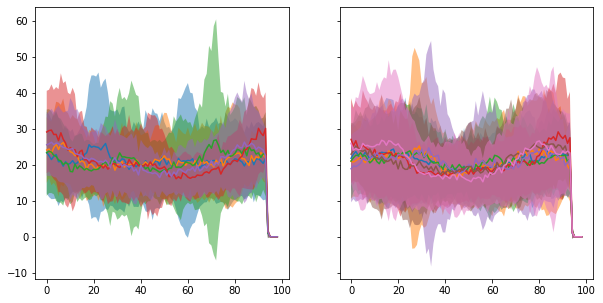

In [371]:
fig,ax = plt.subplots(1,2, figsize = (10,5),sharey=True)
x = np.arange(con_shuffle_hist_array.shape[-1])
for mean, std in zip(mean_shuffle_con, std_shuffle_con):
    ax[0].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[0].plot(x, mean)
for mean, std in zip(mean_shuffle_exp, std_shuffle_exp):
    ax[1].fill_between(x, mean+std, mean-std, alpha = 0.5)
    ax[1].plot(x, mean)

In [372]:
# Calculate confidence intervals for each animal, for each timepoint
con_shuffle_hist_array = np.moveaxis(con_shuffle_hist_array,0,-1)
exp_shuffle_hist_array = np.moveaxis(exp_shuffle_hist_array,0,-1)

In [373]:
## Only looking for values HIGHER than control. NOT INTERESTED in below control

con_cis = np.zeros(con_shuffle_hist_array.shape[:-1], dtype = np.object)
con_cis_sig = np.zeros(con_cis.shape)
alpha = 0.01
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(con_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        con_cis[animal_num,time_num] = ci_bounds
        condition = con_diff_tau_hists[animal_num,time_num] > ci_bounds[1]
        if condition:
            con_cis_sig[animal_num,time_num] = 1
            
exp_cis = np.zeros(exp_shuffle_hist_array.shape[:-1], dtype = np.object)
exp_cis_sig = np.zeros(exp_cis.shape)
wanted_percs = (100*(alpha/2),100*(1-(alpha)/2)) 
for animal_num,animal in enumerate(exp_shuffle_hist_array):
    for time_num,time in enumerate(animal):
        ci_bounds = np.percentile(animal.flatten(), wanted_percs)
        exp_cis[animal_num,time_num] = ci_bounds
        expdition = exp_diff_tau_hists[animal_num,time_num] > ci_bounds[1]
        if expdition:
            exp_cis_sig[animal_num,time_num] = 1

Text(0.5, 1.0, 'Experimental')

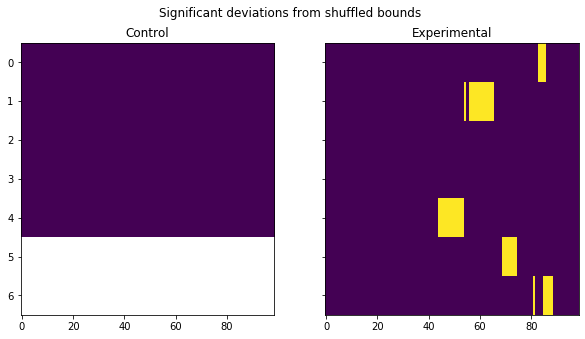

In [375]:
fig,ax = plt.subplots(1,2, figsize = (10,5),sharey=True)
plt.suptitle('Significant deviations from shuffled bounds')
ax[0].imshow(con_cis_sig, aspect = 'auto')
ax[0].set_title('Control')
ax[1].imshow(exp_cis_sig, aspect = 'auto')
ax[1].set_title('Experimental')

In [376]:
mean_vals = []
for animal in exp_cis_sig:
    if sum(animal):
        mean_vals.append(np.mean(bins[np.where(animal)[0]]))

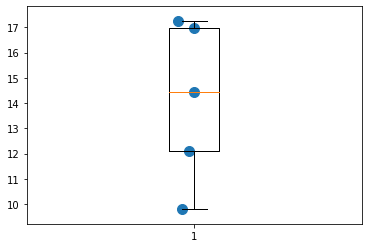

In [377]:
plt.boxplot(mean_vals);
plt.scatter(np.ones(len(mean_vals))+(np.random.random(len(mean_vals))-0.5)*0.1, mean_vals, s= 100)